***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "08"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [6]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [8]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [9]:
def binarize_predictions(dataframe):
    dataframe = dataframe.copy()
    dataframe["pred_bin"] = -1
    bin_limits = np.arange(1.5, 30, 1.)
    
    cut_left = -np.inf
    for cut_right in bin_limits:
        idx = dataframe.query("@cut_left <= pred < @cut_right").index
        dataframe.loc[idx, "pred_bin"] = int(cut_right)
        cut_left = cut_right
        
    idx = dataframe.query("pred >= @cut_right").index
    dataframe.loc[idx, "pred_bin"] = 30
    
    return dataframe

***
## loading data for assessment

In [10]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .query("inventory_days <= 30")
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    display(dataset)

,sku,ds,y,current_price,currency,listing_type_classic,listing_type_premium,shipping_logistic_type_fulfillment,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_payment_free_shipping,shipping_payment_paid_shipping,minutes_active,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,q_mean,q_std,target_stock,inventory_days,item_domain_id,item_id,site_id,product_id,product_family_id
0,0,2021-02-16,0,179.990005,REA,30,0,3,27,0,30,0,1172.370605,4,5,5,4,4,4,4,0.215558,0.482631,1,30.0,MLB-SNEAKERS,492155,MLB,None,MLB15832732
1,0,2021-02-17,0,179.990005,REA,30,0,4,26,0,30,0,1172.370605,4,4,5,5,4,4,4,0.215558,0.482631,1,29.0,MLB-SNEAKERS,492155,MLB,None,MLB15832732
2,0,2021-02-18,0,179.990005,REA,30,0,5,25,0,30,0,1172.370605,4,4,4,5,5,4,4,0.215558,0.482631,1,28.0,MLB-SNEAKERS,492155,MLB,None,MLB15832732
3,0,2021-02-19,0,179.990005,REA,30,0,6,24,0,30,0,1172.370605,4,4,4,4,5,5,4,0.215558,0.482631,1,27.0,MLB-SNEAKERS,492155,MLB,None,MLB15832732
4,0,2021-02-20,0,179.990005,REA,30,0,7,23,0,30,0,1172.370605,4,4,4,4,4,5,5,0.215558,0.482631,1,26.0,MLB-SNEAKERS,492155,MLB,None,MLB15832732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10519465,660914,2021-02-26,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,5,5,4,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None
10519466,660914,2021-02-27,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,4,5,5,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None
10519467,660914,2021-02-28,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,4,4,4,4,4,5,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None
10519468,660914,2021-03-01,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,5,4,4,4,4,4,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None


In [11]:
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")

In [12]:
dataset.sku.nunique()

441834

In [13]:
dataset.query("nrows == 30").sku.nunique()

235867

In [14]:
# just for assessment
dataset = dataset.query("nrows == 30").reset_index(drop=True)
dataset

,sku,ds,y,current_price,currency,listing_type_classic,listing_type_premium,shipping_logistic_type_fulfillment,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_payment_free_shipping,shipping_payment_paid_shipping,minutes_active,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,q_mean,q_std,target_stock,inventory_days,item_domain_id,item_id,site_id,product_id,product_family_id,nrows
0,6,2021-02-01,0,490.000000,MEX,30,0,30,0,0,30,0,1440.000000,5,5,4,4,4,4,4,0.619325,0.633861,3,4.0,MLM-TABLET_CASES,345180,MLM,None,None,30
1,6,2021-02-02,2,490.000000,MEX,30,0,30,0,0,30,0,1440.000000,4,5,5,4,4,4,4,0.619325,0.633861,3,3.0,MLM-TABLET_CASES,345180,MLM,None,None,30
2,6,2021-02-03,0,490.000000,MEX,30,0,30,0,0,30,0,1392.130005,4,4,5,5,4,4,4,0.619325,0.633861,3,7.0,MLM-TABLET_CASES,345180,MLM,None,None,30
3,6,2021-02-04,1,490.000000,MEX,30,0,30,0,0,30,0,1344.130005,4,4,4,5,5,4,4,0.619325,0.633861,3,6.0,MLM-TABLET_CASES,345180,MLM,None,None,30
4,6,2021-02-05,1,490.000000,MEX,30,0,30,0,0,30,0,1296.130005,4,4,4,4,5,5,4,0.619325,0.633861,3,5.0,MLM-TABLET_CASES,345180,MLM,None,None,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7076005,660914,2021-02-26,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,5,5,4,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None,30
7076006,660914,2021-02-27,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,4,4,4,4,4,5,5,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None,30
7076007,660914,2021-02-28,1,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,4,4,4,4,4,5,0.423169,0.759259,5,8.0,MLB-SNEAKERS,490874,MLB,None,None,30
7076008,660914,2021-03-01,0,59.990002,REA,0,30,30,0,0,0,30,1440.000000,5,5,4,4,4,4,4,0.423169,0.759259,5,9.0,MLB-SNEAKERS,490874,MLB,None,None,30


In [15]:
print(dataset.ds.min(), "-", dataset.ds.max())

2021-02-01 00:00:00 - 2021-03-02 00:00:00


In [16]:
train_dset = dataset.query("ds == '2021-02-01'").reset_index(drop=True)
valid_dset = dataset.query("ds == '2021-03-02'").reset_index(drop=True)

In [17]:
train_dset.sku.nunique()

235867

In [18]:
valid_dset.sku.nunique()

235867

In [19]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [20]:
train_dset.loc[:,categs_cols].nunique()

item_domain_id    7386
product_id        5749
dtype: int64

In [21]:
encoder = ce.OrdinalEncoder()
train_dset[categs_cols] = encoder.fit_transform(train_dset[categs_cols])
valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

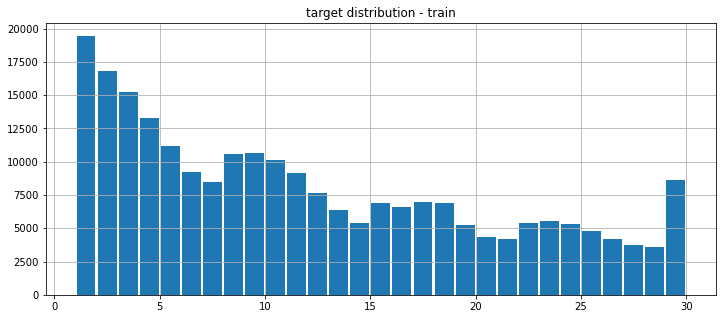

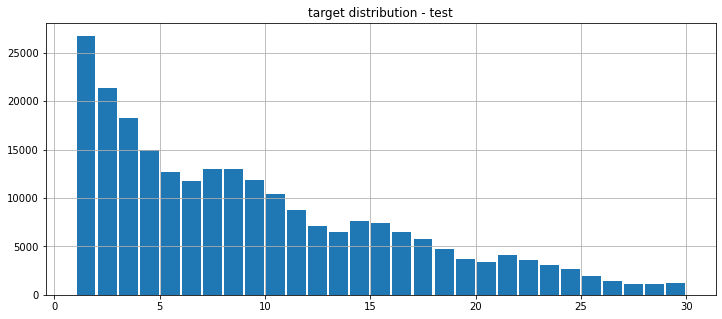

In [22]:
plt.figure(figsize=(12,5))
plt.hist(train_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(valid_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

***
## model training: assessment

In [23]:
model_params = {
    'objective': 'huber',
    'metric': 'l1',
    'max_bin': 127,
    'num_leaves': 63,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.95,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': True,
    'bin_construct_sample_cnt':20000000,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
    'feature_pre_filter': True,
    'first_metric_only': True,
}

------------------------------------------------------------------------------------------
Preparing model for site: MLA
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 21119, number of used features: 14
[LightGBM] [Info] Start training from score 11.159288
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 5.64572	valid_1's l1: 6.68954
[100]	valid_0's l1: 5.24082	valid_1's l1: 6.23577
[150]	valid_0's l1: 4.91585	valid_1's l1: 5.85299
[200]	valid_0's l1: 4.68803	valid_1's l1: 5.55155
[250]	valid_0's l1: 4.50845	valid_1's l1: 5.27142
[300]	valid_0's l1: 4.41328	valid_1's l1: 5.0698
[350]	valid_0's l1: 4.36531	valid_1's l1: 4.91074
[400]	valid_0's l1: 4.35104	valid_1's l1: 4.78968
Early stopping, best iteration is:
[396]	valid_0's l1: 4.35058	valid_1's l1: 4.7979
Evaluated only: l1


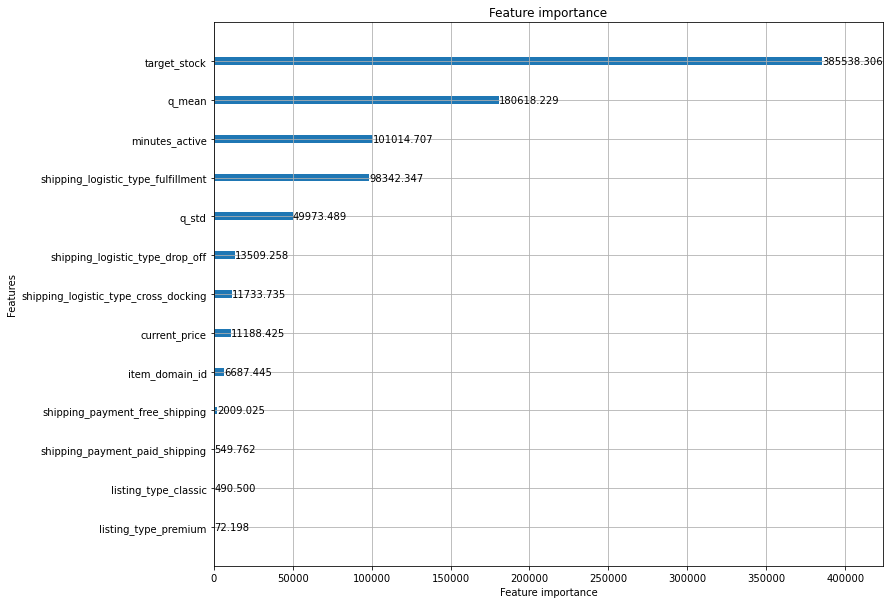

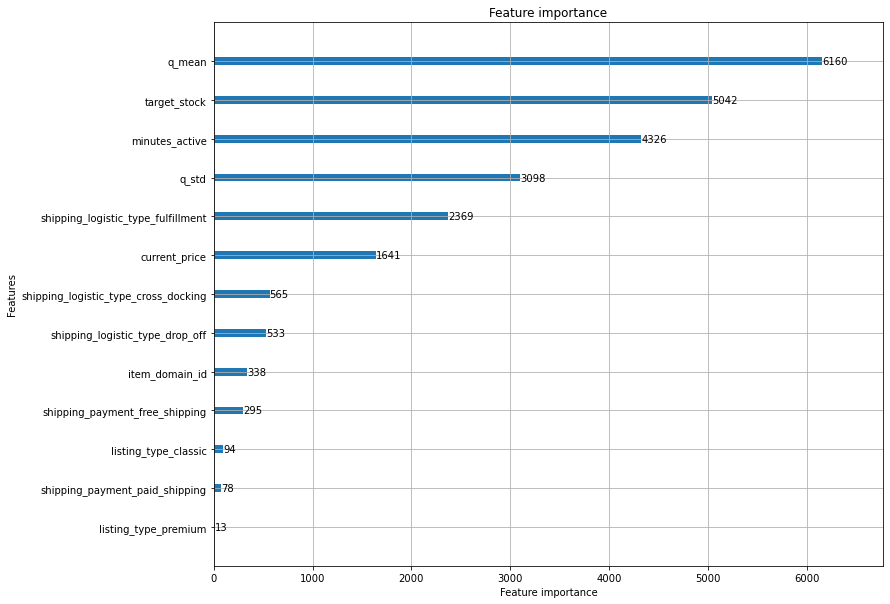

------------------------------------------------------------------------------------------
Preparing model for site: MLB
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 115868, number of used features: 14
[LightGBM] [Info] Start training from score 11.868894
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 5.98529	valid_1's l1: 6.683
[100]	valid_0's l1: 5.58982	valid_1's l1: 6.24424
[150]	valid_0's l1: 5.26203	valid_1's l1: 5.86282
[200]	valid_0's l1: 5.02703	valid_1's l1: 5.57121
[250]	valid_0's l1: 4.83633	valid_1's l1: 5.31311
[300]	valid_0's l1: 4.72216	valid_1's l1: 5.12832
[350]	valid_0's l1: 4.65058	valid_1's l1: 4.98463
[400]	valid_0's l1: 4.6127	valid_1's l1: 4.87648
[450]	valid_0's l1: 4.60688	valid_1's l1: 4.79738
Early stopping, best iteration is:
[445]	valid_0's l1: 4.60604	valid_1's l1: 4.80432
Evaluated only: l1


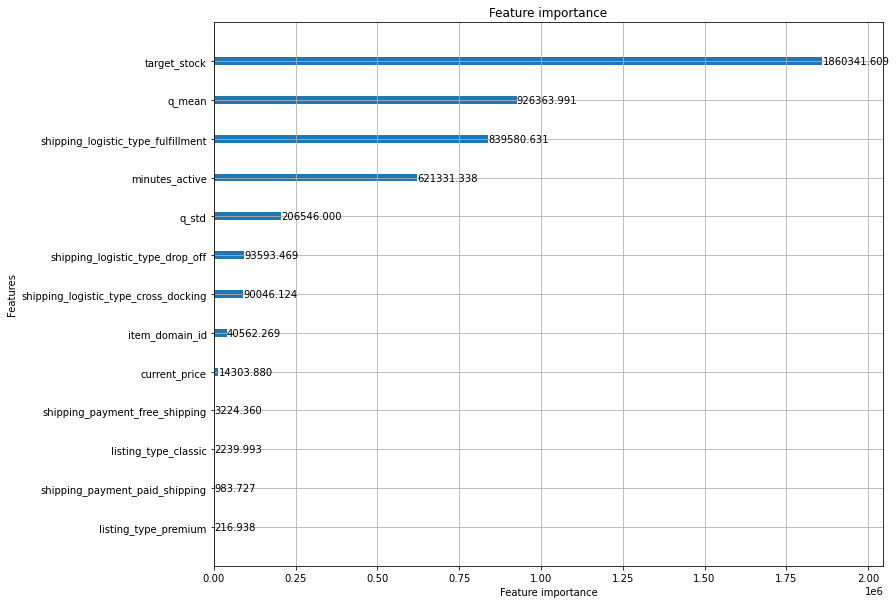

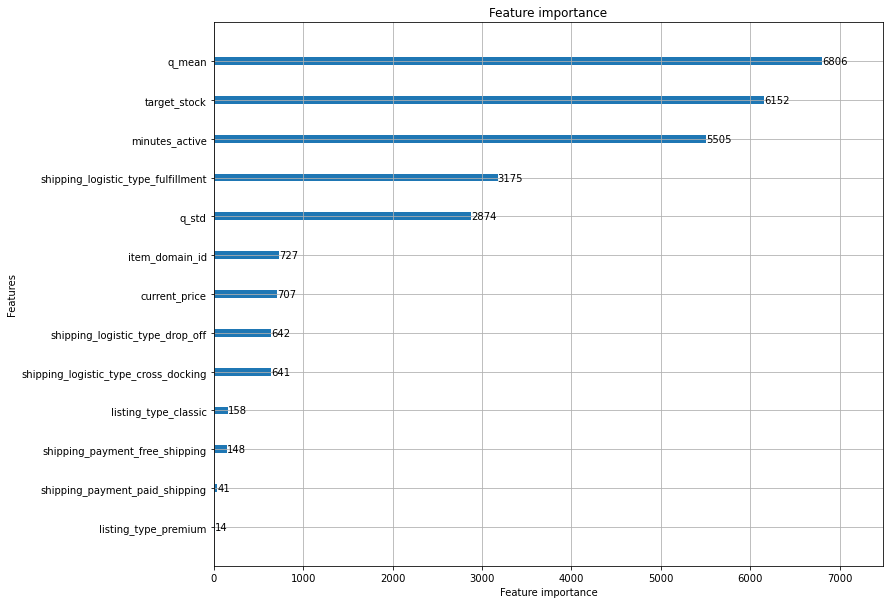

------------------------------------------------------------------------------------------
Preparing model for site: MLM
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 98880, number of used features: 14
[LightGBM] [Info] Start training from score 11.407423
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 5.89102	valid_1's l1: 6.56184
[100]	valid_0's l1: 5.49593	valid_1's l1: 6.10213
[150]	valid_0's l1: 5.1673	valid_1's l1: 5.70368
[200]	valid_0's l1: 4.92841	valid_1's l1: 5.39737
[250]	valid_0's l1: 4.73226	valid_1's l1: 5.13067
[300]	valid_0's l1: 4.62492	valid_1's l1: 4.94923
[350]	valid_0's l1: 4.56573	valid_1's l1: 4.81011
[400]	valid_0's l1: 4.53712	valid_1's l1: 4.70671
[450]	valid_0's l1: 4.54057	valid_1's l1: 4.6306
Early stopping, best iteration is:
[417]	valid_0's l1: 4.53563	valid_1's l1: 4.67814
Evaluated only: l1


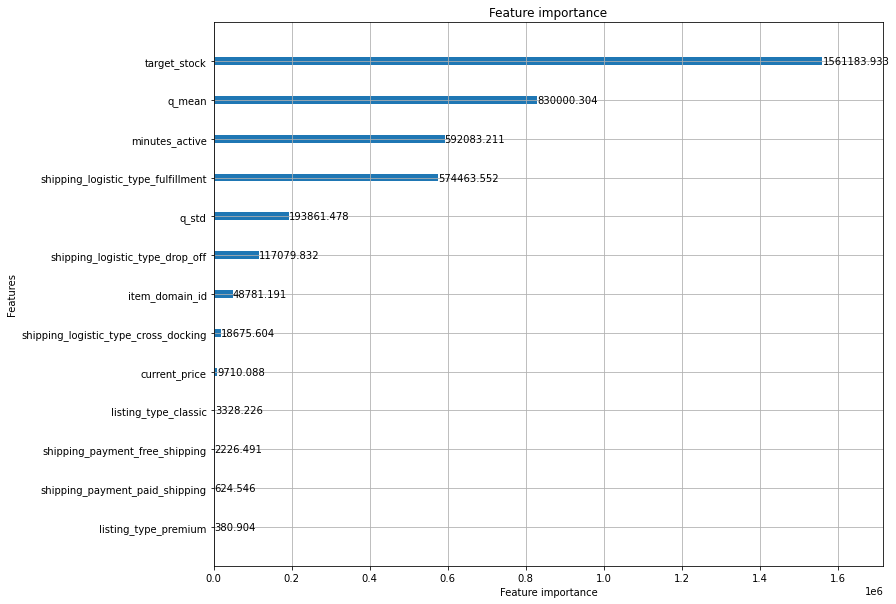

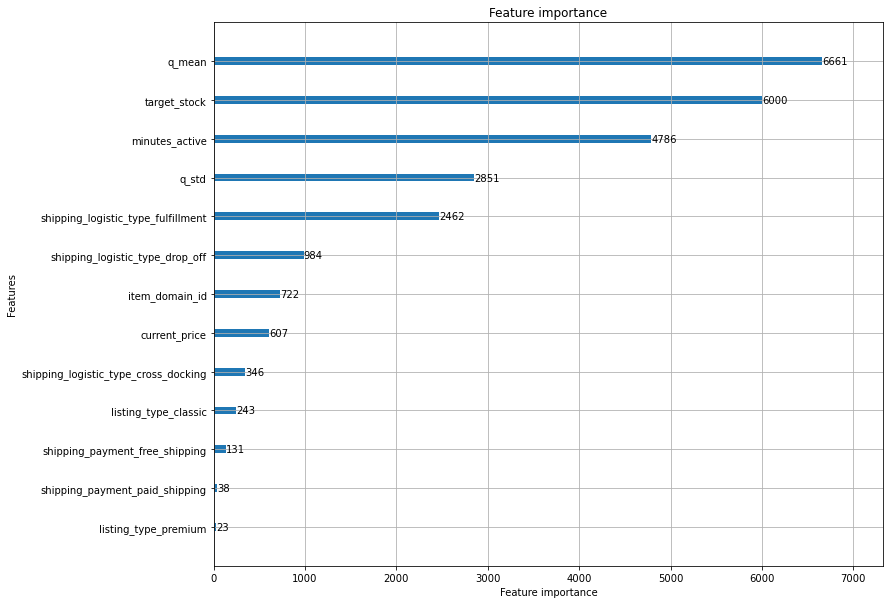

In [24]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

oof_preds = list()

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")
    
    _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
    _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)
    sample_index = _train_dset.sample(frac=0.25).index

    train_dset_lgb = lgb.Dataset(
        data = _train_dset.loc[:, numeric_cols+categs_cols],
        label= _train_dset.loc[:, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    train_dset_sample_lgb = lgb.Dataset(
        data = _train_dset.loc[sample_index, numeric_cols+categs_cols],
        label= _train_dset.loc[sample_index, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    valid_dset_lgb = lgb.Dataset(
        data = _valid_dset.loc[:, numeric_cols+categs_cols],
        label= _valid_dset.loc[:, target].values,
        categorical_feature = categs_cols,
        free_raw_data=False   
    )
    model = lgb.train(
        params = model_params,
        train_set = train_dset_lgb,
        valid_sets = [valid_dset_lgb, train_dset_sample_lgb],
        num_boost_round = 5000,
        early_stopping_rounds = 50,
        verbose_eval = 50,
    )

    lgb.plot_importance(model, importance_type="gain", figsize=(12,10))
    lgb.plot_importance(model, importance_type="split", figsize=(12,10))
    plt.show()
    
    _valid_dset["pred"] = model.predict(_valid_dset[numeric_cols+categs_cols])
    _valid_dset = binarize_predictions(_valid_dset)
    oof_preds.append(_valid_dset)
    models_by_site.append(model)

In [25]:
for site,model in zip(sites,models_by_site):
    print(site, "-", f"best_iteration: {model.best_iteration}", "-", f"best_score: {model.best_score['valid_0']['l1']}")

MLA - best_iteration: 396 - best_score: 4.35058171860784
MLB - best_iteration: 445 - best_score: 4.606038605787267
MLM - best_iteration: 417 - best_score: 4.5356329614643816


***
## analysis of OOF predictions

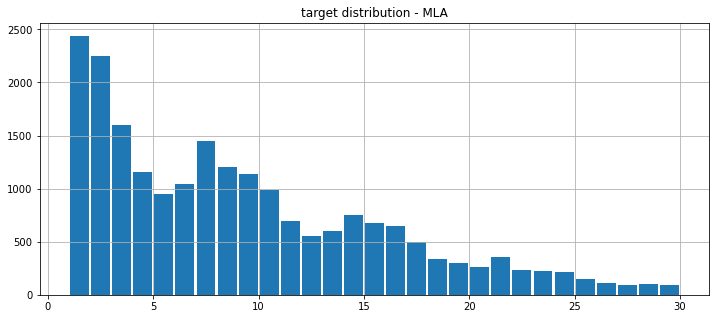

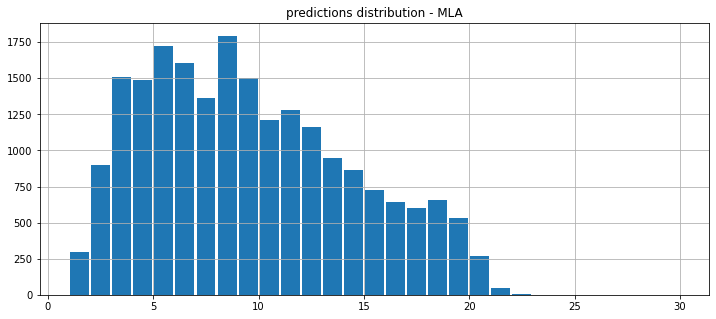

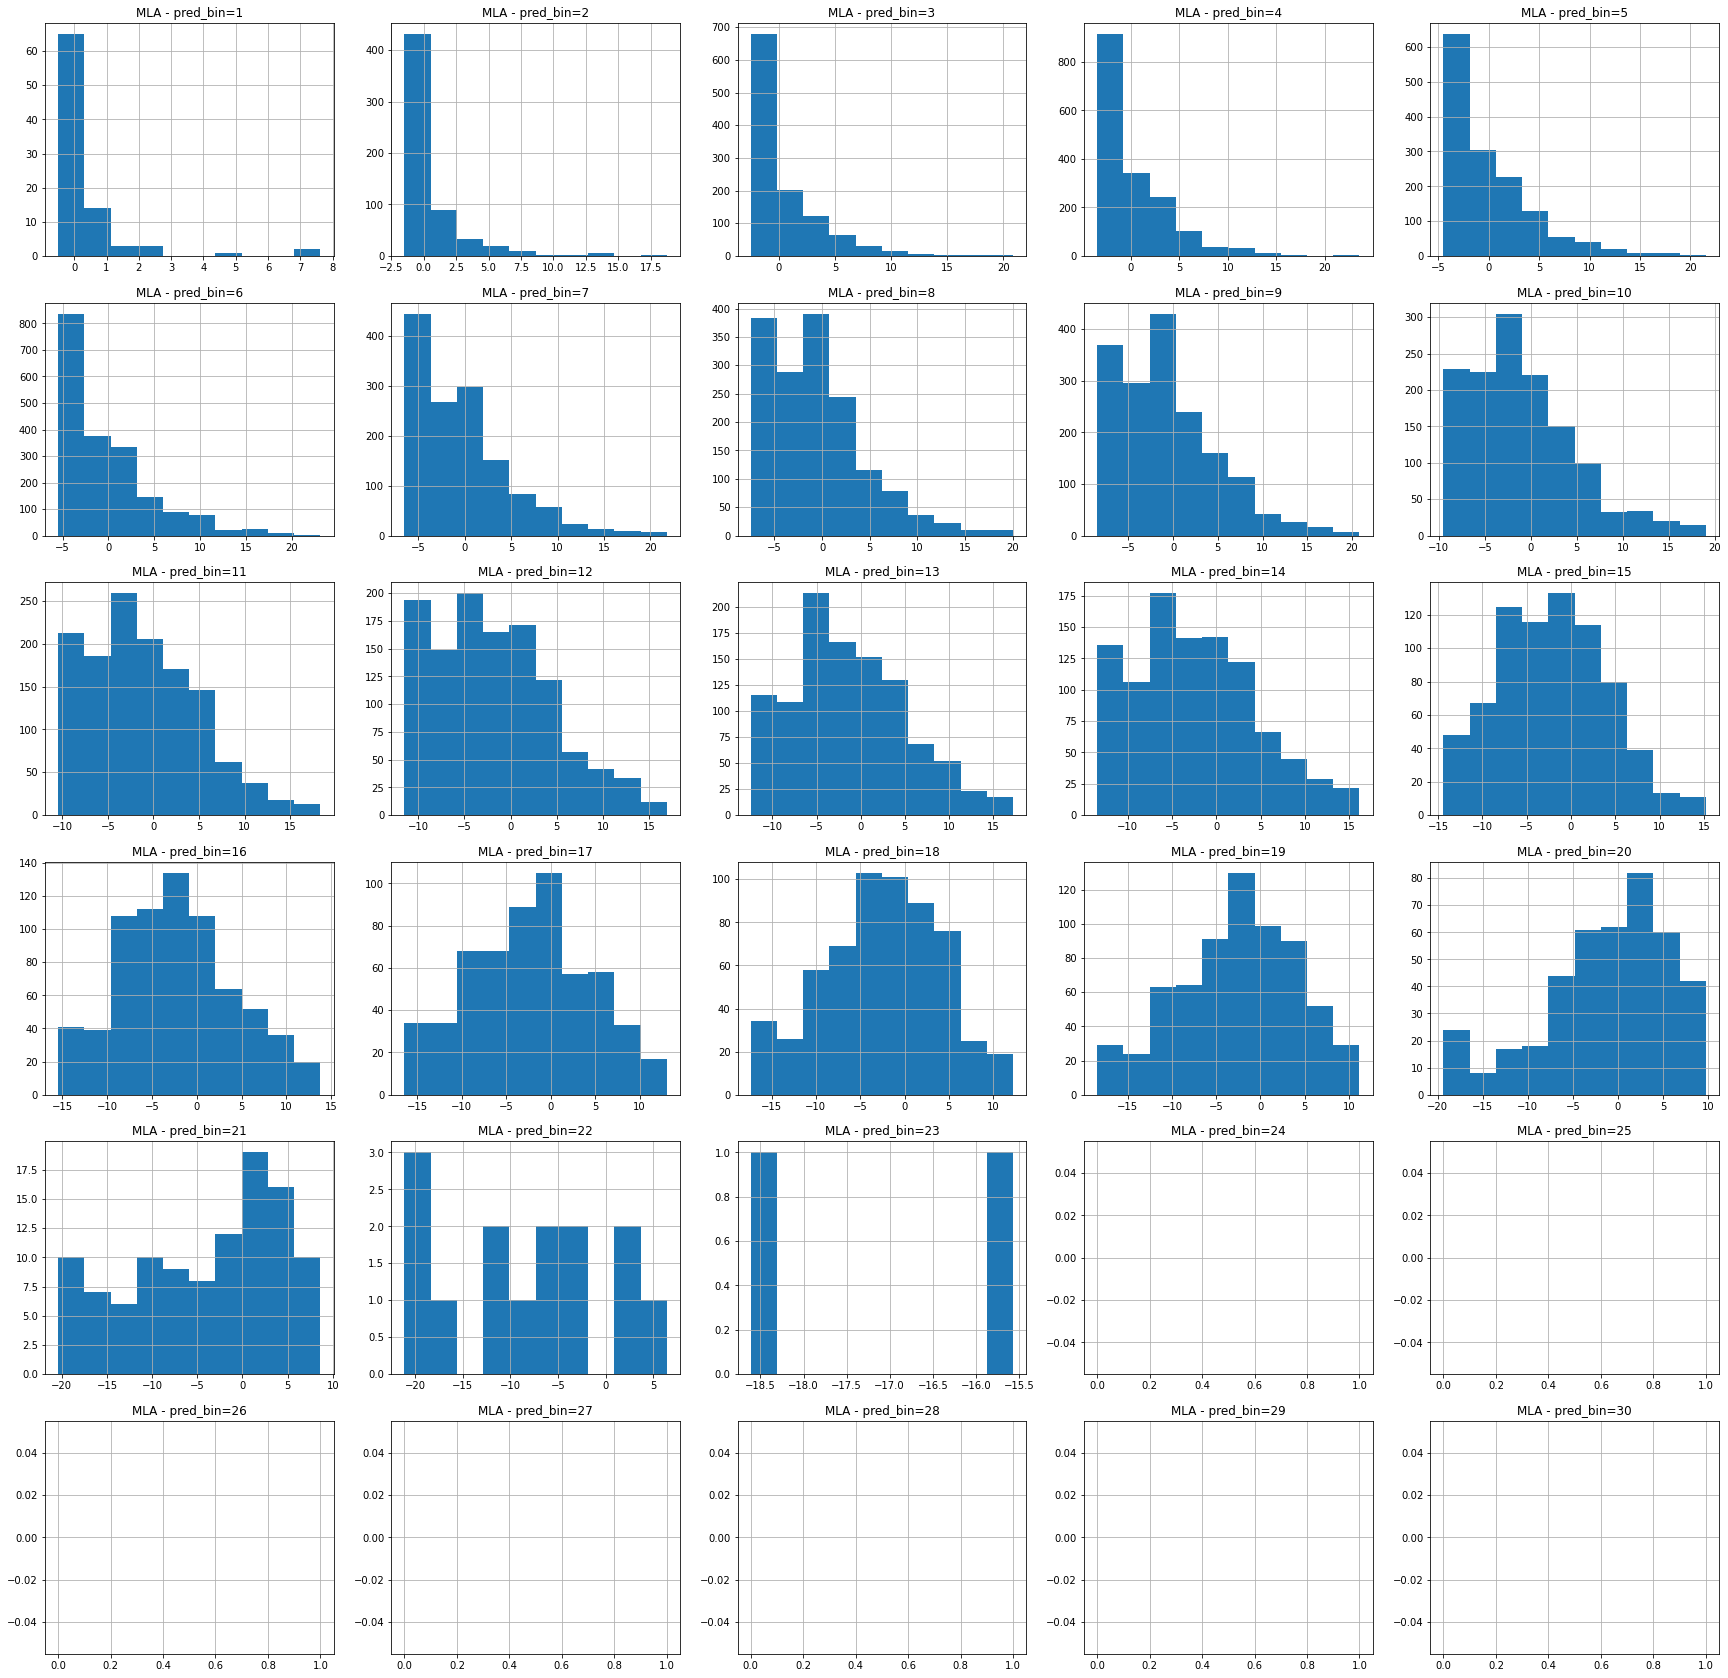

In [26]:
# results for MLA
plt.figure(figsize=(12,5))
plt.hist(oof_preds[0][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[0]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[0].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLA - pred_bin={d}")
    plt.grid()
plt.show()

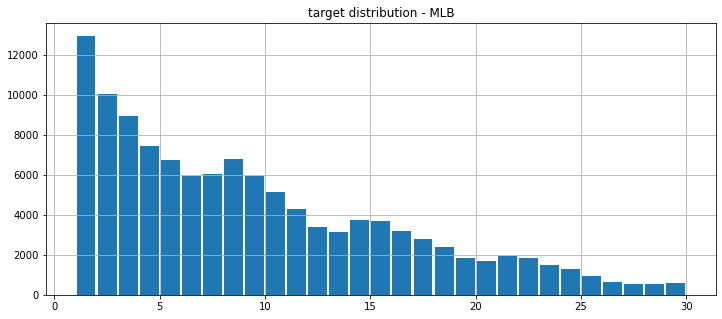

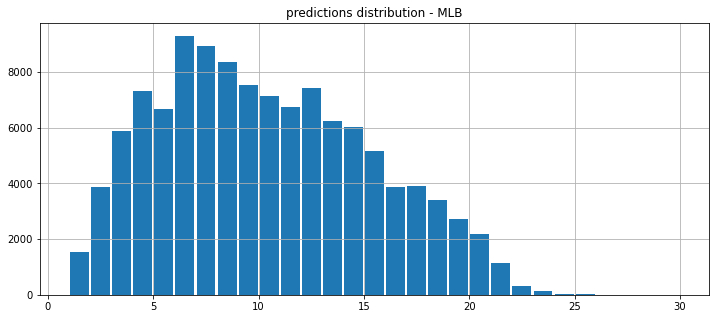

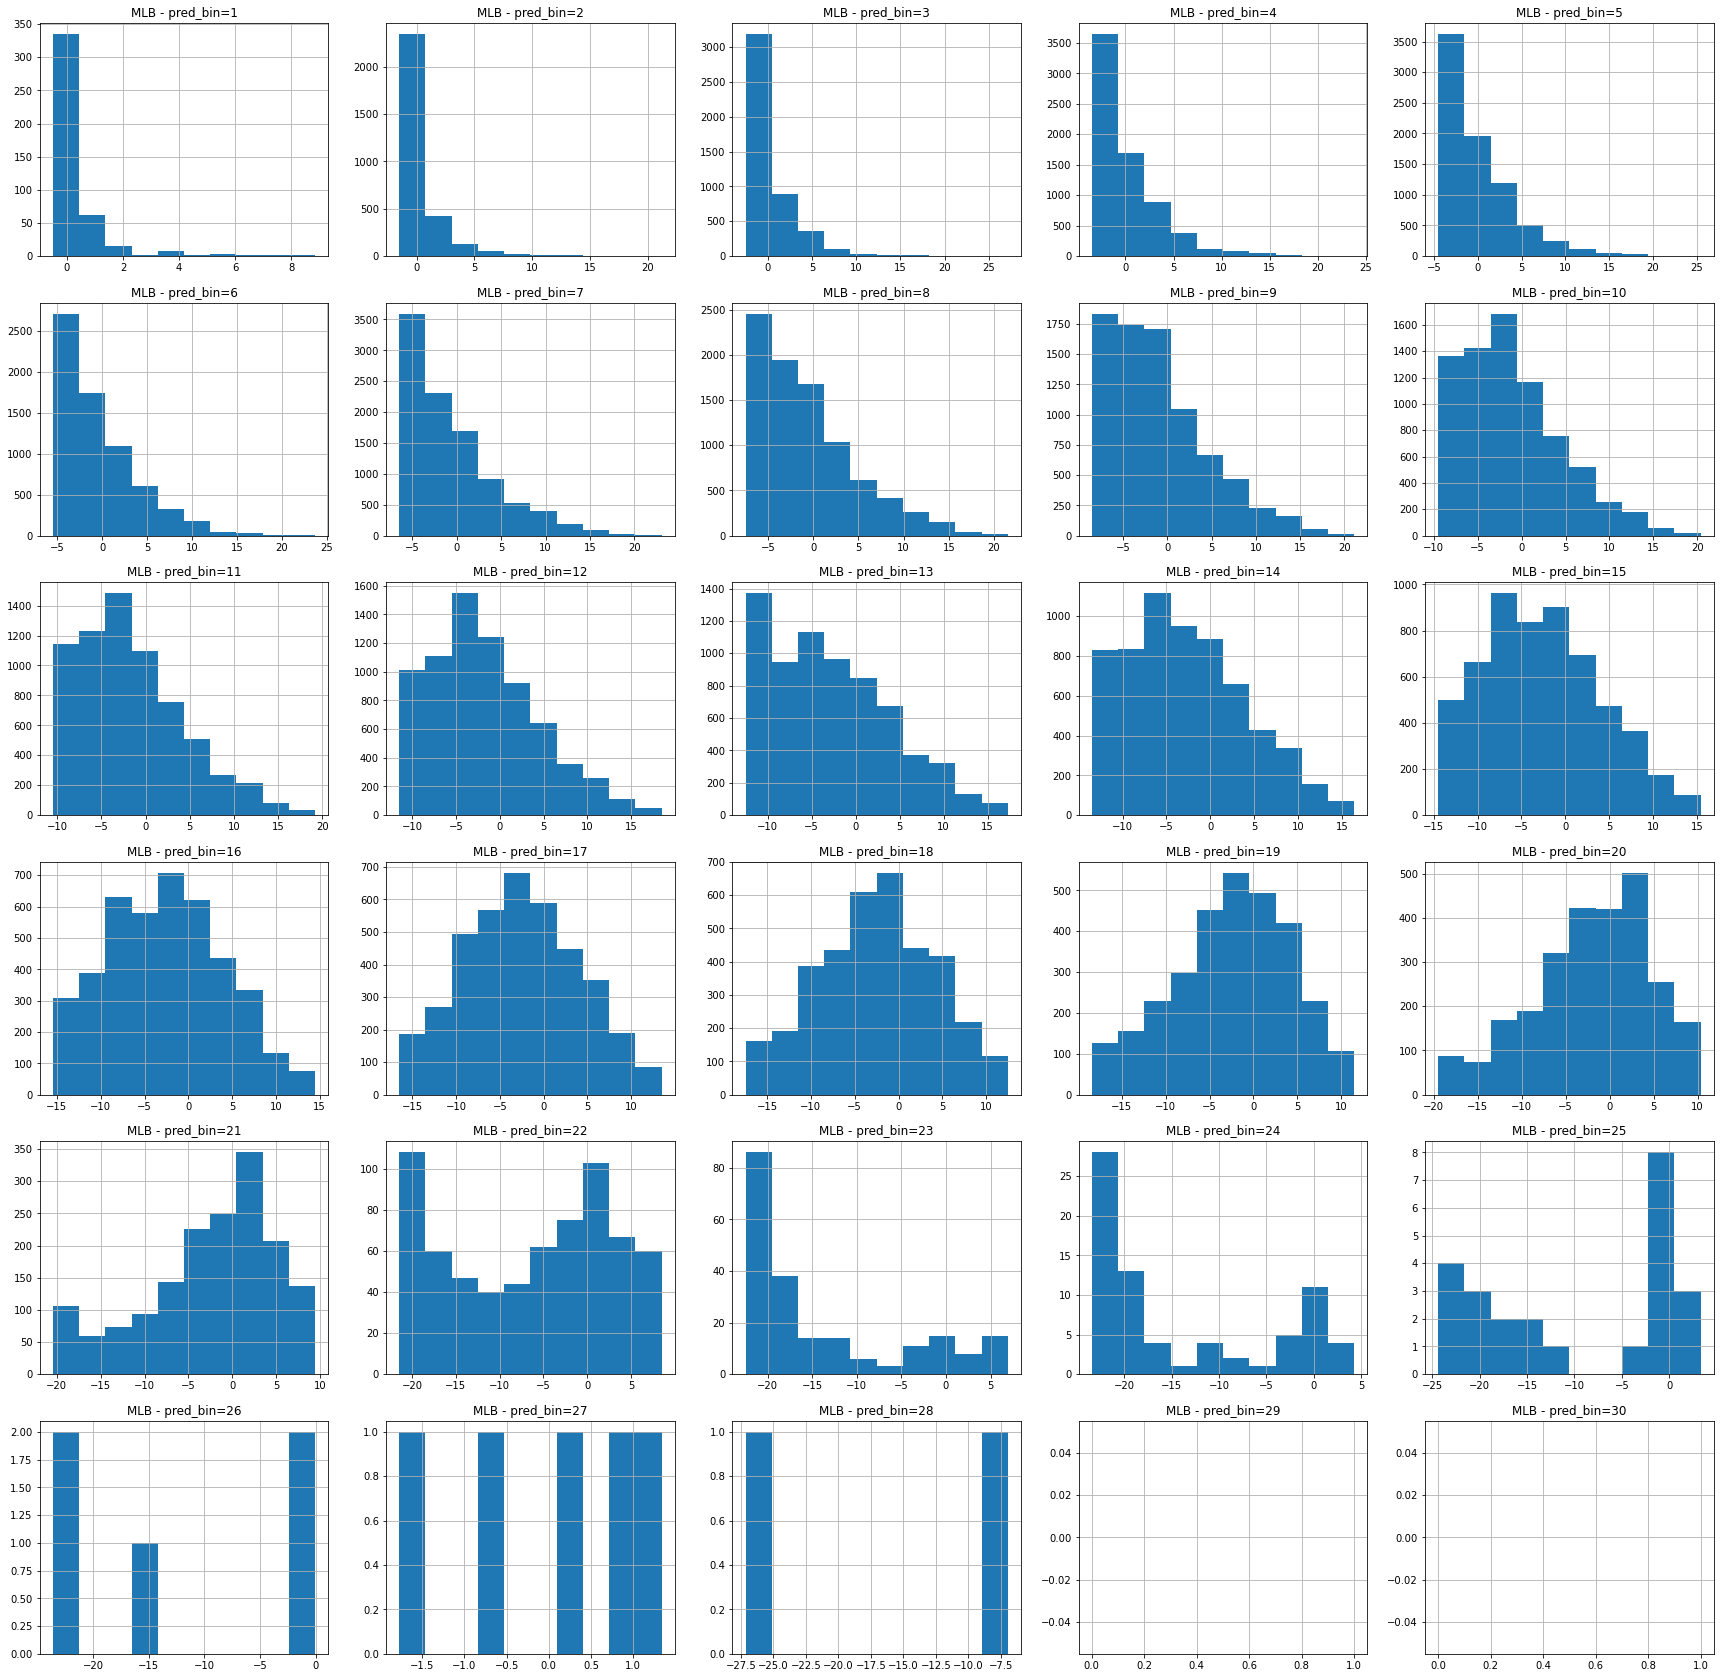

In [27]:
# results for MLB

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[1].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLB - pred_bin={d}")
    plt.grid()
plt.show()

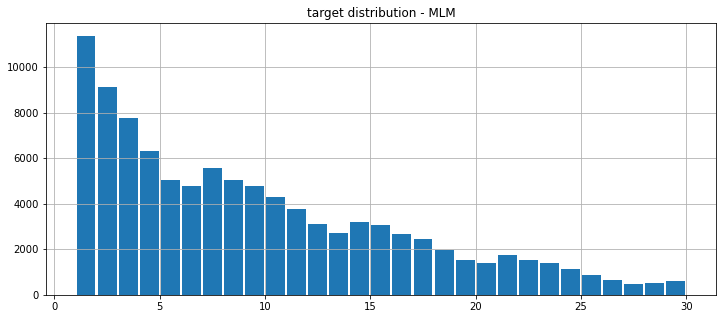

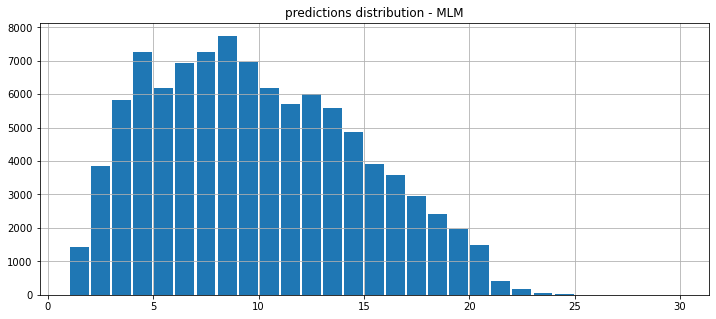

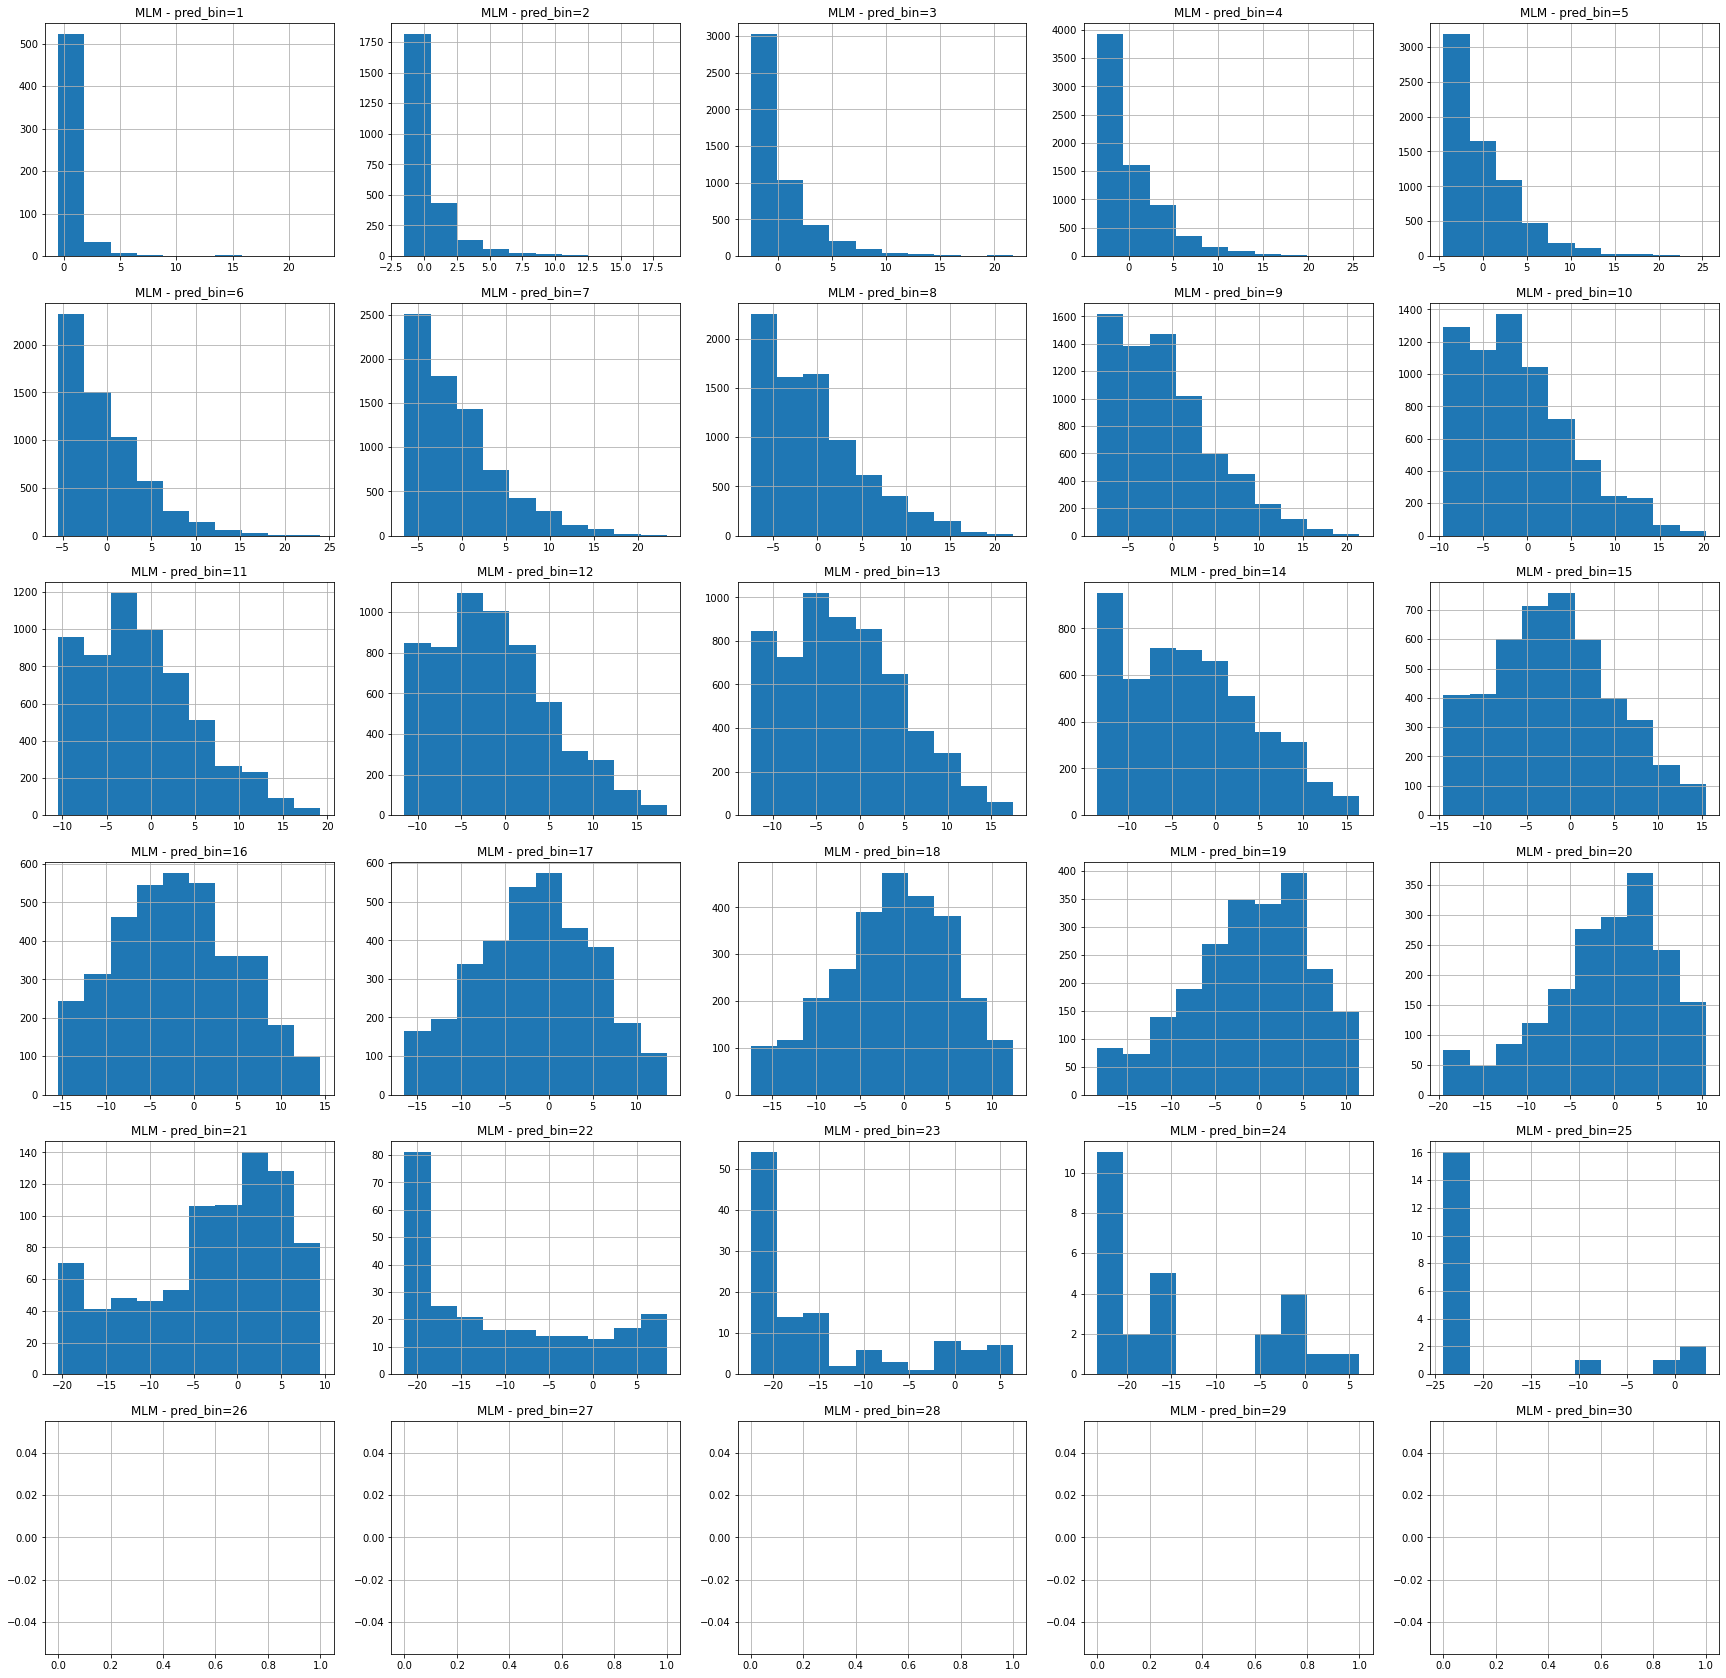

In [28]:
# results for MLM

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[2].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLM - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

***